# Data analysis: individual fairness for SMI

In [299]:
import simulation as sim

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import ast

import math

In [2]:
def read_sims(no, first_sim=0, path='Simulation_results/'):
    '''Constructs simulations for no many previously run ones.
    no = the number of simulations to be loaded
    path = the folder where the config and run files are'''

    all_sims = []
    for n in range(first_sim, first_sim + no):
        s = sim.Simulation(path + 'config' + str(n) + '.csv')
        # to save time, we only read the results of a simulation when needed
        s.read(False)
        all_sims.append(s)

    return all_sims

In [3]:
# read the data
sims = read_sims(20000)

In [4]:
sns.set(rc={'figure.figsize':(4.7,5.27)})
sns.set_theme(style="ticks")

## Functions for ploting the chance of an IF outcome for different users

In [8]:
def get_if_IF(popularity):
    
    num_CCs = len(popularity)

    # get the inexes of CCs by the number of followers
    popularity = np.array(popularity)
    ordered_by_popualrity = np.flip(popularity.argsort())
    id_to_position_popualrity = {i:pos for pos, i in enumerate(ordered_by_popualrity)}
    # print(ordered_by_popualrity)

    # find if fair (CC_i is in terms of popularity on the position it deserves or more twoards the top)
    def is_fair(i):
        return int(id_to_position_popualrity[i] <= i)
    
    return [is_fair(i) for i in range(num_CCs)]

In [407]:
def data_IF(all_sims, fixed_pars = {}, x="CCs", y="num_followers", hue = "alpha",
                            print_progress = True, measure_at_time = 0, style = None):
    '''Creates a dataframe with bars grouped by x, traking y, and with hue being the type users or CCs'''
    
    
    # x_label = '&'.join(x)
    y_label = 'average_' + y
    # d = {x_label:[], y_label:[], hue_label:[], 'timestep':[]}
    d = {x:[], y_label:[], hue:[], 'timestep':[]}
    
    j = 0
    for s in all_sims:
        j+=1
        if j%1000 == 0 and print_progress:
            print(j)
        have = True
        for p in fixed_pars:
            if p in s.config:
                if str(s.config[p]) not in fixed_pars[p]:
                    have = False
        
        if have:
            results = s.return_results()
            # x_val = '&'.join([str(s.config[par]) for par in x])
            
            # if we want to find the %of CC who have IF results, results[y] need to be computed
            if y == 'CC_is_IF':
                if style is None:
                    results[y] = get_if_IF(results['num_followers'][measure_at_time])
                else:
                    results[y] = [get_if_IF(results['num_followers'][i]) 
                                  for i, t in enumerate(s.config['record_at_timesteps'])]
            else:
                results[y_label] = results[y][measure_at_time]
            
            if style is not None:
                for i, t in enumerate(s.config['record_at_timesteps']):
                    for c in range(s.config['num_CCs']):
                        d[hue].append(s.config[hue])
                        d[style].append(t)
                        d[x].append(c)
                        d[y_label].append(results[y][i][c])
            elif x == "CCs":
                for c in range(s.config['num_CCs']):
                    d[hue].append(s.config[hue])
                    d[x].append(c)
                    d[y_label].append(results[y][c])
            elif x == "timestep" and y=="did_converge":
                for i, t in enumerate(s.config['record_at_timesteps']):
                    d[hue].append(s.config[hue])
                    d[x].append(t)
                    d[y_label].append(results[y][i])
            elif x == "timestep":
                # if it converges faster, we keep the results of the last
                max_i = len(results[y_label])
                for i in range(1000):
                    d[hue].append(s.config[hue])
                    d[x].append(i+1)
                    if i<max_i:
                        d[y_label].append(results[y_label][i] + 1)
                    else:
                        d[y_label].append(results[y_label][-1] + 1)
                        
                #for i, val in enumerate(results[y_label]):
                #    d[hue].append(s.config[hue])
                #    d[x].append(i+1)
                #    d[y_label].append(results[y_label][i] + 1)
                    
        
    return pd.DataFrame(data=d)

In [370]:
df_convergence = data_IF(sims, x = 'timestep', y = 'did_converge')

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000


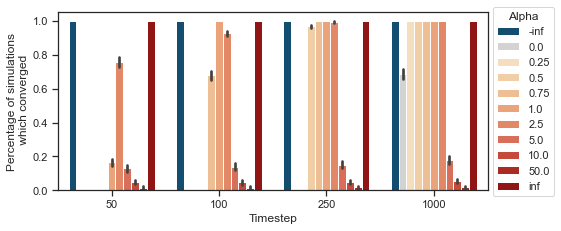

In [442]:
sns.set(rc={'figure.figsize':(7.7,3.27)})
sns.set_theme(style="ticks")

# alpha_list = [-1000, -50.0, -10.0, -5.0, -2.5, -1.0, -0.75, -0.5, -0.25, 0, 0 , 0.25, 0.5, 0.75, 1, 2.5, 5, 10, 50, 1000]
alpha_list = [-1000, 0 , 0.25, 0.5, 0.75, 1, 2.5, 5, 10, 50, 1000]
df_convergence_aux = df_convergence[df_convergence['alpha'].isin(alpha_list)]
df_convergence_aux = df_convergence_aux[df_convergence_aux['timestep'].isin([50, 100, 250, 1000])]

ax = sns.barplot(data=df_convergence_aux, x="timestep", y="average_did_converge", hue="alpha", palette = palette)

# Legend and titles
lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
labels[0] = '-inf'
labels[-1] = 'inf'
ax.legend(lines, labels, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, title = 'Alpha')
ax.set(ylabel="Percentage of simulations\n which converged", xlabel='Timestep')

# Save
fig = ax.get_figure()
fig.savefig("convergence.png", dpi = 600, bbox_inches="tight")

In [444]:
# number of simulations which converged
df_convergence[df_convergence['alpha'] == -1000]['average_did_converge'].sum()

5000

In [408]:
fp = {'alpha': ['-10.0', '-5.0', '-2.5', '-1.0', '0', '1', '2.5', '5', '10']}
df_IF_timesteps = data_IF(sims, x = 'CCs', y = 'CC_is_IF', style = 'timestep', fixed_pars = fp)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000


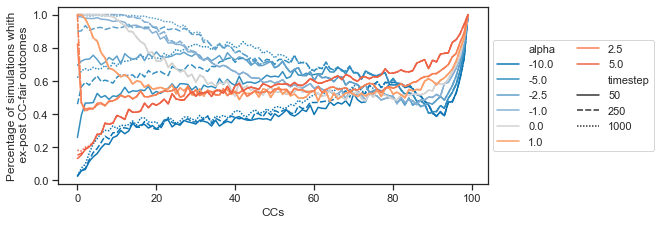

In [413]:
alpha_list = [-10, -5, -2.5, -1, 0 , 1, 2.5, 5]
df_IF_timesteps_aux = df_IF_timesteps[df_IF_timesteps['alpha'].isin(alpha_list)]
df_IF_timesteps_aux = df_IF_timesteps_aux[df_IF_timesteps_aux['timestep'].isin([50, 250, 1000])]
ax = sns.lineplot(data=df_IF_timesteps_aux, x='CCs', y='average_CC_is_IF', ci=None, hue='alpha',
                  style = 'timestep', estimator = np.mean, palette = palette, legend = 'full')

# Legend and titles
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol = 2)
ax.set(ylabel='Percentage of simulations whith\n ex-post CC-fair outcomes')

# Save
fig = ax.get_figure()
fig.savefig("IF_at_timesteps.png", dpi = 600, bbox_inches="tight")

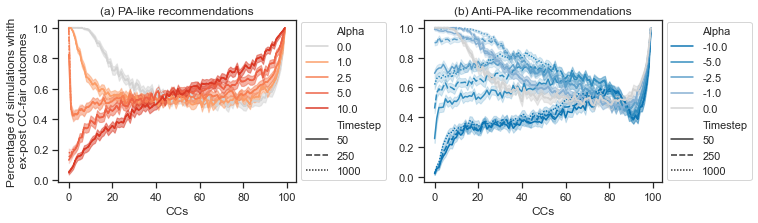

In [438]:
sns.set(rc={'figure.figsize':(10.7,3.27)})
sns.set_theme(style="ticks")

fig, axs = plt.subplots(1, 2)
#fig.suptitle('CC-fairness for different recommendation processes')

# values of alphas for each subplot
alpha_list = []
#alpha_list.append([-1.0, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1])
alpha_list.append([0, 0.25, 0.5, 0.75, 1, 2.5, 5, 10, 50, 1000])
alpha_list.append([0, -0.25, -0.5, -0.75, -1, -2.5, -5, -10, -50, -1000])

# subtitles for each subplot
titles = ['(a) PA-like recommendations', '(b) Anti-PA-like recommendations']

# legend to be included at the end
all_alphas = [-1000, -50.0, -10.0, -5.0, -2.5, -1.0, -0.75, -0.5, -0.25, 0, 0 , 0.25, 0.5, 0.75, 1, 2.5, 5, 10, 50, 1000]
# alphas_lbl = [-float('inf'), -50.0, -10.0, -5.0, -2.5, -1.0, -0.75, -0.5, -0.25, 0, 0 , 0.25, 0.5, 0.75, 1, 2.5, 5, 10, 50, float('inf')]
handles_list = [mpl.patches.Patch(color=palette[a], label=alphas_lbl[i]) for i, a in enumerate(all_alphas)]

for i in range(2):
    # Plot subplot_i
    df_aux = df_IF_timesteps[df_IF_timesteps['alpha'].isin(alpha_list[i])]
    df_aux = df_aux[df_aux['timestep'].isin([50, 250, 1000])]
    # df_user_satisfaction_aux = df_user_satisfaction_aux[df_user_satisfaction_aux['did_converge'] == True]
    sns.lineplot(data=df_aux, x='CCs', y='average_CC_is_IF', ci=95, hue='alpha',
                 style = 'timestep', estimator = np.mean, palette = palette, ax=axs[i])
    
    # Arrange legend
    lines_labels = [axs[i].get_legend_handles_labels()]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    labels[0] = 'Alpha'
    labels[6] = 'Timestep'
    axs[i].legend(lines, labels, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    
    # Common y label
    if i==0:
        axs[i].set(ylabel='Percentage of simulations whith\n ex-post CC-fair outcomes')
    else:
        axs[i].set(ylabel=None)
    
    # Set title
    axs[i].set_title(titles[i])

fig.tight_layout()
fig.savefig("IF_at_timesteps_CI95.png", dpi = 600, bbox_inches="tight")

In [426]:
lines

In [402]:
df_IF_timesteps.head

<bound method NDFrame.head of Empty DataFrame
Columns: [CCs, average_CC_is_IF, alpha, timestep]
Index: []>

## Plots for Seeker Satisfaction

In [363]:
df_user_satisfaction = data_IF(sims, x = 'timestep', y = 'average_pos_best_CC', measure_at_time = -1)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000


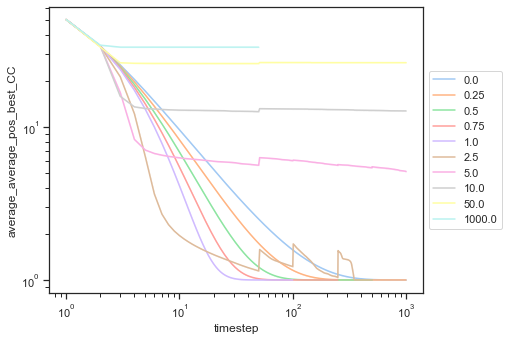

In [68]:
sns.set(rc={'figure.figsize':(6.7,5.27)})
sns.set_theme(style="ticks")
# palette = sns.diverging_palette(207, 25, center="light", as_cmap=True)
# palette = sns.color_palette("Spectral", as_cmap=True)
palette = sns.color_palette("pastel", 10)

# alpha_list = [-50.0, -10.0, -5.0, -2.5, -1.0, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 2.5, 5, 10, 50]
# alpha_list = [-1.0, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1]
alpha_list = [0, 0.25, 0.5, 0.75, 1, 2.5, 5, 10, 50, 1000]
# alpha_list = [0, -0.25, -0.5, -0.75, -1, -2.5, -5, -10, -50, -1000]
# alpha_list = [-1.0, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1]
df_user_satisfaction_aux = df_user_satisfaction[df_user_satisfaction['timestep'].isin(range(1005))]
df_user_satisfaction_aux = df_user_satisfaction_aux[df_user_satisfaction_aux['alpha'].isin(alpha_list)]
ax = sns.lineplot(data=df_user_satisfaction_aux, x='timestep', y='average_average_pos_best_CC', ci=0, hue='alpha', palette = palette, legend = 'full')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xscale('log')
plt.yscale('log')
# 'full' for legents shows all; 'linear' --> remove xscale


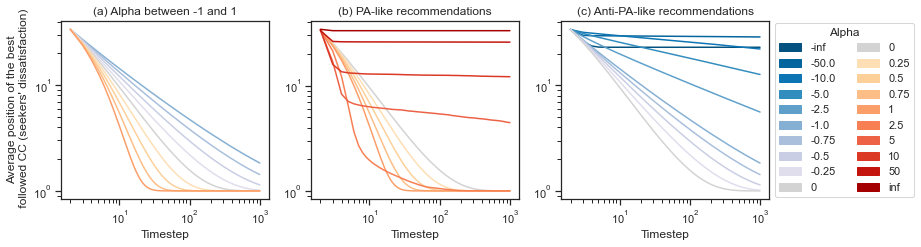

In [475]:
sns.set(rc={'figure.figsize':(12.7,3.27)})
sns.set_theme(style="ticks")

fig, axs = plt.subplots(1, 3)
#fig.suptitle('CC-fairness for different recommendation processes')

# values of alphas for each subplot
alpha_list = []
alpha_list.append([-1.0, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1])
alpha_list.append([0, 0.25, 0.5, 0.75, 1, 2.5, 5, 10, 50, 1000])
alpha_list.append([0, -0.25, -0.5, -0.75, -1, -2.5, -5, -10, -50, -1000])

# subtitles for each subplot
titles = ['(a) Alpha between -1 and 1', '(b) PA-like recommendations', '(c) Anti-PA-like recommendations']

# legend to be included at the end
all_alphas = [-1000, -50.0, -10.0, -5.0, -2.5, -1.0, -0.75, -0.5, -0.25, 0, 0 , 0.25, 0.5, 0.75, 1, 2.5, 5, 10, 50, 1000]
alphas_lbl = [-float('inf'), -50.0, -10.0, -5.0, -2.5, -1.0, -0.75, -0.5, -0.25, 0, 0 , 0.25, 0.5, 0.75, 1, 2.5, 5, 10, 50, float('inf')]
handles_list = [mpl.patches.Patch(color=palette[a], label=alphas_lbl[i]) for i, a in enumerate(all_alphas)]

for i in range(3):
    # Plot subplot_i
    df_user_satisfaction_aux = df_user_satisfaction[df_user_satisfaction['alpha'].isin(alpha_list[i])]
    df_user_satisfaction_aux = df_user_satisfaction_aux[df_user_satisfaction_aux['timestep'].isin(range(2, 1005))]
    # df_user_satisfaction_aux = df_user_satisfaction_aux[df_user_satisfaction_aux['did_converge'] == True]
    sns.lineplot(data=df_user_satisfaction_aux, x='timestep', y='average_average_pos_best_CC', ci=None, hue='alpha',
                 estimator = np.mean, palette = palette, legend = 'full', ax=axs[i])
    
    # Logarithmic scale
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    
    # Show legend only at final plot
    if i == 2:
        axs[i].legend(handles=handles_list, loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, title = 'Alpha')
        # axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, labels = alpha_labels, title = 'Alpha')
    else:
        axs[i].get_legend().remove()
    
    # Common y label
    if i==0:
        axs[i].set(ylabel="Average position of the best\n followed CC (seekers' dissatisfaction)", xlabel='Timestep')
    else:
        axs[i].set(ylabel=None, xlabel='Timestep')
    
    # Set title
    axs[i].set_title(titles[i])

fig.savefig("seeker_sat_mean.png", dpi = 600, bbox_inches="tight")

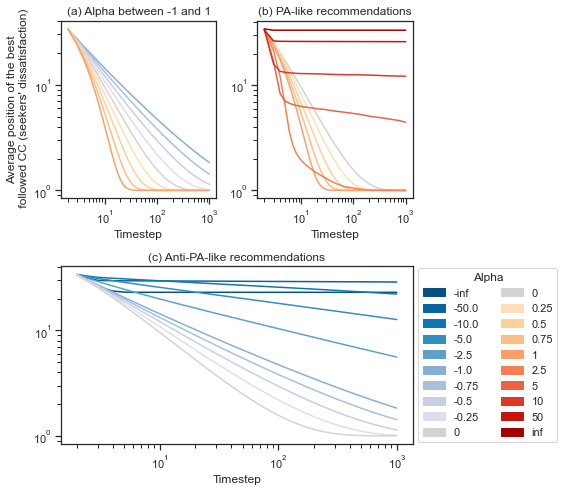

In [479]:
sns.set(rc={'figure.figsize':(12.7,3.27)})
sns.set_theme(style="ticks")

#fig, axs = plt.subplots(1, 3)
fig = plt.figure(figsize=(8, 7))
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,1,2)
axs = [ax1, ax2, ax3]
#fig.suptitle('CC-fairness for different recommendation processes')

# values of alphas for each subplot
alpha_list = []
alpha_list.append([-1.0, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1])
alpha_list.append([0, 0.25, 0.5, 0.75, 1, 2.5, 5, 10, 50, 1000])
alpha_list.append([0, -0.25, -0.5, -0.75, -1, -2.5, -5, -10, -50, -1000])

# subtitles for each subplot
titles = ['(a) Alpha between -1 and 1', '(b) PA-like recommendations', '(c) Anti-PA-like recommendations']

# legend to be included at the end
all_alphas = [-1000, -50.0, -10.0, -5.0, -2.5, -1.0, -0.75, -0.5, -0.25, 0, 0 , 0.25, 0.5, 0.75, 1, 2.5, 5, 10, 50, 1000]
alphas_lbl = [-float('inf'), -50.0, -10.0, -5.0, -2.5, -1.0, -0.75, -0.5, -0.25, 0, 0 , 0.25, 0.5, 0.75, 1, 2.5, 5, 10, 50, float('inf')]
handles_list = [mpl.patches.Patch(color=palette[a], label=alphas_lbl[i]) for i, a in enumerate(all_alphas)]

for i in range(3):
    # Plot subplot_i
    df_user_satisfaction_aux = df_user_satisfaction[df_user_satisfaction['alpha'].isin(alpha_list[i])]
    df_user_satisfaction_aux = df_user_satisfaction_aux[df_user_satisfaction_aux['timestep'].isin(range(2, 1005))]
    # df_user_satisfaction_aux = df_user_satisfaction_aux[df_user_satisfaction_aux['did_converge'] == True]
    sns.lineplot(data=df_user_satisfaction_aux, x='timestep', y='average_average_pos_best_CC', ci=None, hue='alpha',
                 estimator = np.mean, palette = palette, legend = 'full', ax=axs[i])
    
    # Logarithmic scale
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    
    # Show legend only at final plot
    if i == 2:
        axs[i].legend(handles=handles_list, loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, title = 'Alpha')
        # axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, labels = alpha_labels, title = 'Alpha')
    else:
        axs[i].get_legend().remove()
    
    # Common y label
    if i==0:
        axs[i].set(ylabel="Average position of the best\n followed CC (seekers' dissatisfaction)", xlabel='Timestep')
    else:
        axs[i].set(ylabel=None, xlabel='Timestep')
    
    # Set title
    axs[i].set_title(titles[i])

fig.tight_layout()
fig.savefig("seeker_sat_mean_test.png", dpi = 600, bbox_inches="tight")

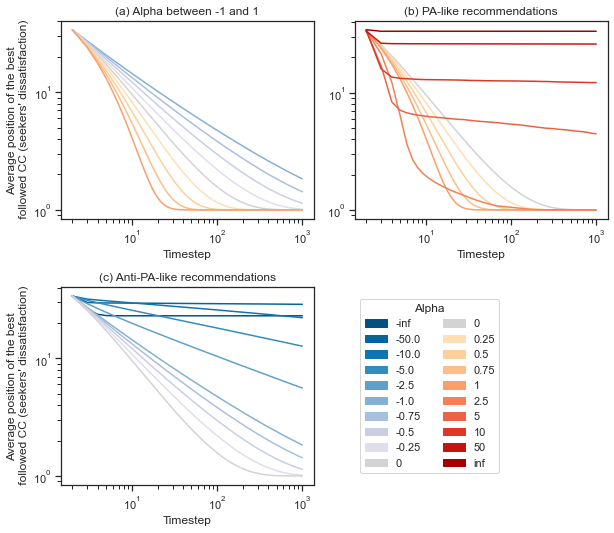

In [482]:
sns.set(rc={'figure.figsize':(8.7,7.57)})
sns.set_theme(style="ticks")

fig, axs = plt.subplots(2, 2)
#fig.suptitle('CC-fairness for different recommendation processes')

# values of alphas for each subplot
alpha_list = []
alpha_list.append([-1.0, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1])
alpha_list.append([0, 0.25, 0.5, 0.75, 1, 2.5, 5, 10, 50, 1000])
alpha_list.append([0, -0.25, -0.5, -0.75, -1, -2.5, -5, -10, -50, -1000])

# subtitles for each subplot
titles = ['(a) Alpha between -1 and 1', '(b) PA-like recommendations', '(c) Anti-PA-like recommendations', 'Legend']

# legend to be included at the end
all_alphas = [-1000, -50.0, -10.0, -5.0, -2.5, -1.0, -0.75, -0.5, -0.25, 0, 0 , 0.25, 0.5, 0.75, 1, 2.5, 5, 10, 50, 1000]
alphas_lbl = [-float('inf'), -50.0, -10.0, -5.0, -2.5, -1.0, -0.75, -0.5, -0.25, 0, 0 , 0.25, 0.5, 0.75, 1, 2.5, 5, 10, 50, float('inf')]
handles_list = [mpl.patches.Patch(color=palette[a], label=alphas_lbl[i]) for i, a in enumerate(all_alphas)]

c = -1
for (i, j) in [(0, 0), (0, 1), (1, 0), (1, 1)]:
    c+=1
    if i+j != 2:
    # Plot subplot_i
        df_user_satisfaction_aux = df_user_satisfaction[df_user_satisfaction['alpha'].isin(alpha_list[c])]
        df_user_satisfaction_aux = df_user_satisfaction_aux[df_user_satisfaction_aux['timestep'].isin(range(2, 1005))]
        # df_user_satisfaction_aux = df_user_satisfaction_aux[df_user_satisfaction_aux['did_converge'] == True]
        sns.lineplot(data=df_user_satisfaction_aux, x='timestep', y='average_average_pos_best_CC', ci=None, hue='alpha',
                     estimator = np.mean, palette = palette, legend = 'full', ax=axs[i, j])

        # Logarithmic scale
        axs[i, j].set_xscale('log')
        axs[i, j].set_yscale('log')
    
    # Show legend only in final plot
    if i+j == 2:
        axs[i, j].axis('off')
        axs[i, j] = plt.legend(handles=handles_list, loc ='center left', ncol=2, title = 'Alpha')
        # axs[i, j].get_frame().set_edgecolor('w')
        # axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, labels = alpha_labels, title = 'Alpha')
    else:
        axs[i, j].get_legend().remove()
    
    # Common y label
    if j==0:
        axs[i, j].set(ylabel="Average position of the best\n followed CC (seekers' dissatisfaction)", xlabel='Timestep')
    elif i+j != 2:
        axs[i, j].set(ylabel=None, xlabel='Timestep')
    
    # Set title
    if i+j != 2:
        axs[i, j].set_title(titles[c])

fig.tight_layout()
fig.savefig("seeker_sat_mean_test.png", dpi = 600, bbox_inches="tight")

## Plots for IF for CCs

In [10]:
d = data_IF(sims, y = 'CC_is_IF', measure_at_time = -1)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000


In [32]:
50 in d['alpha'].unique()

True

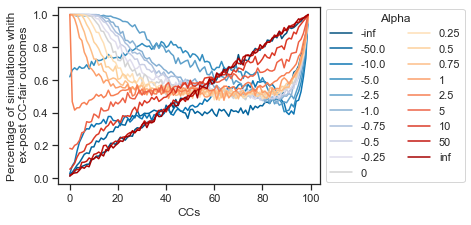

In [313]:
sns.set(rc={'figure.figsize':(4.7,3.27)})
sns.set_theme(style="ticks")

alpha_list = [-1000, -50.0, -10.0, -5.0, -2.5, -1.0, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 2.5, 5, 10, 50, 1000]
# alpha_list = [-1.0, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1]
# alpha_list = [0, 0.25, 0.5, 0.75, 1, 2.5, 5, 10, 50, 1000]
# alpha_list = [0, -0.25, -0.5, -0.75, -1, -2.5, -5, -10, -50, -1000]


# palette = {-1:'#4682B4', 0:'#FAFAFA', 1:'#E49B0F'}
#palette = sns.diverging_palette(207, 25, center="light", as_cmap=True)
# palette = sns.color_palette("Spectral", as_cmap=True)
# palette = sns.color_palette("Set2", 10)
# palette = plt.get_cmap('Blues')
#epsilon = 0.01
#palette_norm = mpl.colors.LogNorm(vmin=min(alpha_list)+epsilon,vmax=max(alpha_list)+epsilon,clip=False)
#palette = plt.get_cmap('twilight_shifted')
#palette_norm = mpl.colors.SymLogNorm(linthresh = 0.25,clip=False, base = 10, vmin = -100, vmax=100)

d_aux = d[d['alpha'].isin(alpha_list)]
ax = sns.lineplot(data=d_aux, x='CCs', y='average_CC_is_IF', ci = None, estimator = np.mean, hue='alpha', 
                  palette = palette, legend = 'full')



# labels and legend
alpha_labels = [-float('inf'), -50.0, -10.0, -5.0, -2.5, -1.0, -0.75, -0.5, -0.25, 0 , 0.25, 0.5, 0.75, 1, 2.5, 5, 10, 50, float('inf')]
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, labels = alpha_labels, title = 'Alpha')
# ax.get_legend().remove()
# ax.figure.colorbar(mpl.cm.ScalarMappable(cmap = palette,norm=palette_norm),label=r'$\alpha$')
plt.ylabel('Percentage of simulations whith\n ex-post CC-fair outcomes')

# save figure
fig = ax.get_figure()
fig.savefig("fair_small.png", dpi = 600, bbox_inches="tight")


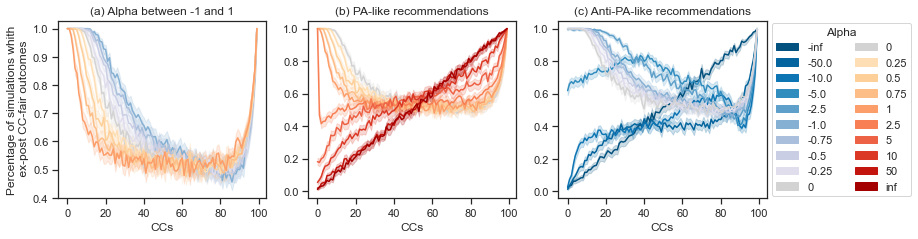

In [355]:
sns.set(rc={'figure.figsize':(12.7,3.27)})
sns.set_theme(style="ticks")

fig, axs = plt.subplots(1, 3)
#fig.suptitle('CC-fairness for different recommendation processes')

# values of alphas for each subplot
alpha_list = []
alpha_list.append([-1.0, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1])
alpha_list.append([0, 0.25, 0.5, 0.75, 1, 2.5, 5, 10, 50, 1000])
alpha_list.append([0, -0.25, -0.5, -0.75, -1, -2.5, -5, -10, -50, -1000])

# subtitles for each subplot
titles = ['(a) Alpha between -1 and 1', '(b) PA-like recommendations', '(c) Anti-PA-like recommendations']

# legend to be included at the end
all_alphas = [-1000, -50.0, -10.0, -5.0, -2.5, -1.0, -0.75, -0.5, -0.25, 0, 0 , 0.25, 0.5, 0.75, 1, 2.5, 5, 10, 50, 1000]
alphas_lbl = [-float('inf'), -50.0, -10.0, -5.0, -2.5, -1.0, -0.75, -0.5, -0.25, 0, 0 , 0.25, 0.5, 0.75, 1, 2.5, 5, 10, 50, float('inf')]
handles_list = [mpl.patches.Patch(color=palette[a], label=alphas_lbl[i]) for i, a in enumerate(all_alphas)]

for i in range(3):
    # Plot subplot_i
    d_aux = d[d['alpha'].isin(alpha_list[i])]
    sns.lineplot(data=d_aux, x='CCs', y='average_CC_is_IF', ci = 95, estimator = np.mean, hue='alpha', 
                 palette = palette, legend = 'full', ax=axs[i])
    
    # Show legend only at final plot
    if i == 2:
        axs[i].legend(handles=handles_list, loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, title = 'Alpha')
        # axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, labels = alpha_labels, title = 'Alpha')
    else:
        axs[i].get_legend().remove()
    
    # Common y label
    if i==0:
        axs[i].set(ylabel='Percentage of simulations whith\n ex-post CC-fair outcomes')
    else:
        axs[i].set(ylabel=None)
    
    # Set title
    axs[i].set_title(titles[i])


fig.savefig("IF_with_CI_95.png", dpi = 600, bbox_inches="tight")

In [332]:
palette(2)

TypeError: 'dict' object is not callable

In [305]:
print(float('inf'))

inf


In [330]:
alpha_list = [-1000, -50.0, -10.0, -5.0, -2.5, -1.0, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 2.5, 5, 10, 50, 1000]
palette = sns.color_palette('PuBu', 10)[1:][::-1]+ ['#D3D3D3']+ sns.color_palette('OrRd', 10)[1:]
palette = {a:palette[i] for i, a in enumerate(alpha_list)}

In [281]:
palette = plt.get_cmap('twilight_shifted')
palette = sns.diverging_palette(207, 25, center="light", as_cmap=True)
sns.color_palette(palette([x/8 for x in range(9)]))

[(0.24349899242866324, 0.5036752614388876, 0.5418001496124608),
 (0.41668023276326976, 0.6152669956421006, 0.644617933649778),
 (0.5925568598340412, 0.7285955396733055, 0.7490359700631644),
 (0.7657381001686477, 0.8401872738765185, 0.8518537541004816),
 (0.9500519246692529, 0.9459052201322822, 0.9450549746474839),
 (0.8934262947490207, 0.7992260608855243, 0.7628152186148421),
 (0.8351820033274064, 0.6526662997832405, 0.5805785269510534),
 (0.7773909885463199, 0.5072471159723535, 0.3997600624364338),
 (0.7216203928993687, 0.3669119007083906, 0.22526315304407996)]

In [204]:
palette = sns.diverging_palette(207, 25, center="dark", as_cmap=True)
sns.color_palette(palette([x/12 for x in range(13)]))

[(0.24349899242866324, 0.5036752614388876, 0.5418001496124608),
 (0.22612860063394227, 0.4451777812776284, 0.4773933646012436),
 (0.20875820883922133, 0.38668030111636925, 0.4129865795900264),
 (0.19014869032328097, 0.32400987012887444, 0.3439853001495305),
 (0.17277829852856003, 0.2655123899676152, 0.2795785151383133),
 (0.15540790673383909, 0.20701490980635606, 0.2151717301270961),
 (0.15075227130662117, 0.13757264257646712, 0.13479195696363658),
 (0.2576863629502935, 0.17840290945262474, 0.1508890472234114),
 (0.34916799021774736, 0.21557437815587255, 0.16555463281924152),
 (0.4466394859372369, 0.255179693024214, 0.1811804650909891),
 (0.5386571383644609, 0.29256896330189486, 0.19593198185241975),
 (0.6301387656319148, 0.32974043200514275, 0.21059756744824984),
 (0.7216203928993687, 0.3669119007083906, 0.22526315304407996)]

In [206]:
extreme1 = palette(0.4)
extreme2 = palette(0.6)

In [228]:
palette = sns.diverging_palette(173, 10, center="light", as_cmap=True)
sns.color_palette(palette([x/10 for x in range(11)]))
pink = palette(0.8)
green = palette(0.2)

In [280]:
palette = sns.color_palette("rocket", as_cmap=True)
sns.color_palette(palette([x/10 for x in range(11)]))

TypeError: 'list' object is not callable

In [221]:
palette = sns.color_palette("mako", as_cmap=True)
sns.color_palette(palette([x/10 for x in range(11)]))

[(0.04503935, 0.01482344, 0.02092227),
 (0.14452486, 0.08824175, 0.16262484),
 (0.2213631, 0.16471913, 0.33041431),
 (0.25406082, 0.2488164, 0.50348932),
 (0.22413977, 0.36487341, 0.60994938),
 (0.20692679, 0.48201774, 0.63812656),
 (0.20431921, 0.59140842, 0.66300179),
 (0.24242624, 0.70522162, 0.67813088),
 (0.3759816, 0.80950627, 0.67641393),
 (0.66129632, 0.8841403, 0.74130658),
 (0.87218969, 0.95960708, 0.89725384)]

In [231]:
palette = sns.light_palette(pink, as_cmap=True)
sns.color_palette(palette([x/4 for x in range(5)]))

[(0.9491482115430626, 0.9419251178565469, 0.9421747939537815),
 (0.9350311642932624, 0.834909102286868, 0.8421166236649822),
 (0.9209141170434622, 0.7278930867171891, 0.7420584533761828),
 (0.906797069793662, 0.6208770711475102, 0.6420002830873835),
 (0.8929006014071399, 0.5155331808211077, 0.5435055217093467)]

In [232]:
palette = sns.light_palette(green, as_cmap=True)
sns.color_palette(palette([x/4 for x in range(5)]))

[(0.9309458447019724, 0.9471507547994574, 0.9436748674211952),
 (0.8255682231737735, 0.8821479630162606, 0.8714890391719277),
 (0.7201906016455746, 0.8171451712330638, 0.7993032109226601),
 (0.6148129801173758, 0.7521423794498672, 0.7271173826733924),
 (0.511081883925555, 0.6881552562882828, 0.6560594579905197)]

In [235]:
palette = sns.dark_palette(pink, as_cmap=True)
sns.color_palette(palette([x/10 for x in range(11)]))

[(0.17639622780978376, 0.1387281441776868, 0.14088519680889236),
 (0.246641754633054, 0.1756698144368457, 0.18035777768148592),
 (0.319697102529255, 0.21408915150637098, 0.22140926178898324),
 (0.3899426293525252, 0.2510308217655299, 0.2608818426615768),
 (0.46299797724872627, 0.28945015883505515, 0.30193332676907414),
 (0.5360533251449273, 0.3278694959045804, 0.3429848108765714),
 (0.6062988519681974, 0.3648111661637393, 0.382457391749165),
 (0.6793541998643984, 0.40323050323326454, 0.4235088758566623),
 (0.7495997266876688, 0.4401721734924235, 0.46298145672925595),
 (0.8226550745838697, 0.47859151056194876, 0.5040329408367532),
 (0.8929006014071399, 0.5155331808211077, 0.5435055217093467)]

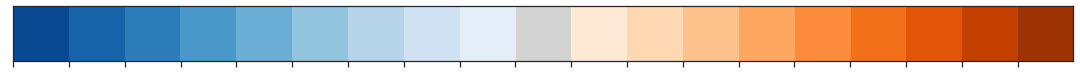

In [257]:
sns.palplot(sns.color_palette('Blues', 11)[2:][::-1]+ ['#D3D3D3']+ sns.color_palette('Oranges', 11)[2:])

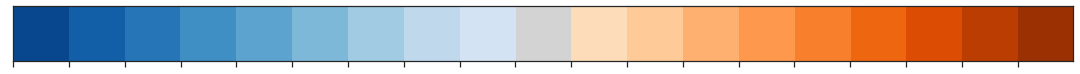

In [260]:
sns.palplot(sns.color_palette('Blues', 10)[1:][::-1]+ ['#D3D3D3']+ sns.color_palette('Oranges', 10)[1:])

In [100]:
type(sns.color_palette("Set2", 10))

seaborn.palettes._ColorPalette

<AxesSubplot: xlabel='CCs', ylabel='average_CC_is_IF'>

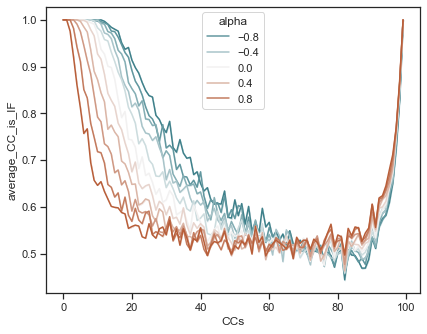

In [68]:
# OLD: with original data
sns.set(rc={'figure.figsize':(6.7,5.27)})
sns.set_theme(style="ticks")
# palette = {-1:'#4682B4', 0:'#FAFAFA', 1:'#E49B0F'}
palette = sns.diverging_palette(207, 25, center="light", as_cmap=True)

d_aux = d[d['alpha'].isin([x/10for x in range(-10, 11, 2)])]
sns.lineplot(data=d_aux, x='CCs', y='average_CC_is_IF', ci=0, hue='alpha', palette = palette, legend = 'brief')
# 'full' for legents shows all


['−0.8', '−0.4', '0.0', '0.4', '0.8']

<AxesSubplot: xlabel='CCs', ylabel='average_CC_is_IF'>

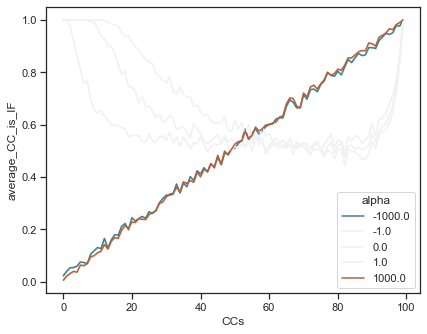

In [69]:
d_aux = d[d['alpha'].isin([0, 1, -1, 1000, -1000])]
sns.lineplot(data=d_aux, x='CCs', y='average_CC_is_IF', ci=0, hue='alpha', palette = palette, legend = True)


In [4]:
def plot_prob_CC_i_fairness_1b(sims, hue='cumulative_weights', logscale=False, fixed_pars={}):
    '''
    make style = 'rs_model' and hue = '%_groupA' '''

    xlabel = 'i (index of content creator)'
    ylabel = 'Probability of CC_i fairness'

    def get_data():
        d = {xlabel: [], ylabel: [], hue: [], style: []}

        # if we order CCs by Borda score --> need the average score by position
        prob_fair = {}
        num_seeds = {}
        positions = {}

        for s in sims:
            # check to see if the fixed parameters have the desired values
            have = True
            for p in fixed_pars:
                if p in s.config:
                    if s.config[p] != fixed_pars[p]:
                        have = False
            if have:
                # if np.array([s.config[i] in fixed_pars[i] for i in fixed_pars]).all():
                # load the results
                s.read()

                num_items = s.config['num_items']

                s_hue = s.config[hue] if type(s.config[hue]) in [
                    int, float] else str(s.config[hue])
                if hue == 'cumulative_weights':
                    s_hue = ast.literal_eval(s_hue)[0][0]
                elif hue == 'prob_cumulative_weights':
                    s_hue = ast.literal_eval(s_hue)[0]

                # get the order of CC based on the borda score
                # --> ordered_CC[k] = index of the kth 'best' CC
                #print(s.results[borda_scoring], s.results['num_followers'])
                borda_score = np.array(s.results[borda_scoring])
                ordered_by_quality_CC = np.flip(borda_score.argsort())
                # print(ordered_by_quality_CC)

                # get the inexes of CCs by the number of followers
                popularity = np.array(s.results['num_followers'])
                ordered_by_popualrity = np.flip(popularity.argsort())
                # print(ordered_by_popualrity)

                # find if fair (if i-th best is in top i by popularity)
                def is_fair(i):
                    return int(ordered_by_quality_CC[i] in ordered_by_popualrity[:(i + 1)])
                fair = [is_fair(i) for i in range(num_items)]
                # print(fair)
                # input()

                # brake the fairness vector into protected and not-protected
                fair_protected = []
                fair_others = []
                position_protected = []
                position_others = []
                for quality_index, id_index in enumerate(ordered_by_quality_CC):
                    if -1 in s.results['maching'][id_index]:
                        fair_protected.append(fair[quality_index])
                        position_protected.append(quality_index)
                    else:
                        fair_others.append(fair[quality_index])
                        position_others.append(quality_index)

                # add to the dictionaries (which keep the runing sum and number of seeds)
                if (s_hue, 'Protected') in prob_fair:
                    prob_fair[(s_hue, 'Protected')] += np.array(fair_protected)
                    prob_fair[(s_hue, 'Others')] += np.array(fair_others)
                    positions[(s_hue, 'Protected')
                              ] += np.array(position_protected)
                    positions[(s_hue, 'Others')] += np.array(position_others)
                    num_seeds[(s_hue, 'Protected')] += 1
                    num_seeds[(s_hue, 'Others')] += 1
                else:
                    prob_fair[(s_hue, 'Protected')] = np.array(fair_protected)
                    prob_fair[(s_hue, 'Others')] = np.array(fair_others)
                    positions[(s_hue, 'Protected')] = np.array(
                        position_protected)
                    positions[(s_hue, 'Others')] = np.array(position_others)
                    num_seeds[(s_hue, 'Protected')] = 1
                    num_seeds[(s_hue, 'Others')] = 1

        print(num_seeds)
        # average the probability of fair outcome over the simulations
        for h in prob_fair:
            #print(prob_fair[s_hue], num_seeds[s_hue])
            prob_fair[h] = prob_fair[h] / num_seeds[h]
            positions[h] = positions[h] / num_seeds[h]

            # construct d
            for i, p in enumerate(prob_fair[h]):
                # d[xlabel].append(i)
                d[xlabel].append(positions[h][i])
                d[ylabel].append(p)
                d[hue].append(h[0])
                d[style].append(h[1])
        print(prob_fair)

        return pd.DataFrame(data=d)

    df = get_data()

    ax = sns.lineplot(data=df, x=xlabel, y=ylabel,
                      ci='sd', hue=hue, style=style)

    plt.show()

In [ ]:
plot_prob_CC_i_fairness_1b(sims, hue='alpha', logscale=False)